# Generative Adversial network (GAN)

Image generation is important in computer vision, to have more training data, or to create new one (like text to image generation: given a textual description,the model generate synthetic images).
The most popular application of GAN is deepfake: creating convincing fake audio and video.

In [ ]:
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from IPython import display
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

In [ ]:
(data_train, label_train), (_,_) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


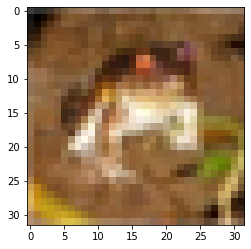

In [ ]:
plt.imshow(data_train[0])

In [ ]:
x_train = data_train[label_train.flatten() == 8]

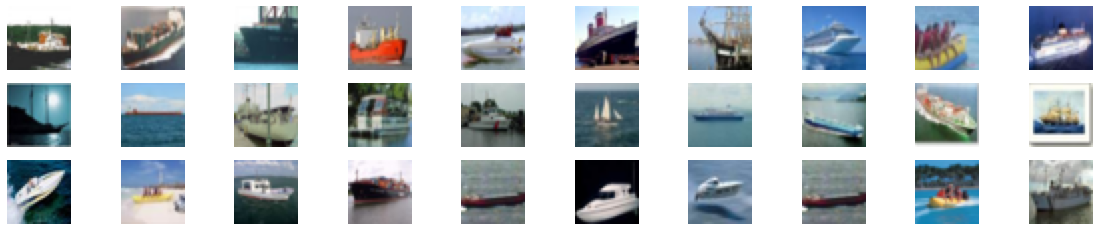

In [ ]:
def plot_random_images(data, number = 10):
    fig, axes = plt.subplots(nrows = number//10, ncols = 10 ,figsize =(20,4))
    axes = axes.reshape(number, )
    random_int = [np.random.randint(0,len(data)) for _ in range(number)]
    random_images = data[random_int]
    for image, axe in zip(random_images, axes):
        axe.imshow(image)
        axe.axis('off')
def plot_fake_images(fake_images, number=10):
    number = number if number<len(fake_images) else len(fake_images)
    fig, axes = plt.subplots(nrows = 1, ncols = number, figsize =(10,2))
    axes = axes.reshape(number,)
    for image, axe in zip(fake_images, axes):
        image = np.clip(image,0,1)
        axe.imshow(image)
        axe.axis("off")


plot_random_images(x_train,30)

# Preprocessing

In [ ]:
BATCH_SIZE = 64

def map_images(img):
    #img = tf.image.rgb_to_grayscale(img)
    img = tf.dtypes.cast(img, tf.float32)
    img = img / 255.0
    return img

# create training batches
dataset = tf.data.Dataset.from_tensor_slices(x_train)
image_dataset = dataset.map(map_images).batch(BATCH_SIZE)

An intuitive way to understand GAN is that suppose you(the generator) want to learn painting, at the beginning you are pretty bad at it.
You do your practice, and your teacher(the discriminator) correct your mistakes, as you progress, your work and the work of your teacher is indistinguable.


In [ ]:

random_normal_dimensions = 128

generator = keras.models.Sequential([
    tf.keras.layers.Dense(8*8*128, input_shape = [random_normal_dimensions]),
    tf.keras.layers.Reshape([8,8,128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(128, kernel_size = 5, strides = 2, padding = 'same', activation = 'selu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size = 5, strides= 1, padding= 'same',activation ='selu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(3, kernel_size = 5, strides= 2, padding= 'same',activation ='tanh')
])

In [ ]:
generator.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 batch_normalization_9 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 16, 16, 128)      409728    
 ranspose)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                     

In [ ]:

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[32, 32, 3]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(256, kernel_size = 5, strides = 2,padding = "SAME",
                        activation = keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(512, kernel_size=5, strides=1 , padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")

])

In [ ]:

d_optimizer = keras.optimizers.RMSprop(learning_rate= 0.0001)
discriminator.compile(loss="binary_crossentropy", optimizer= d_optimizer)
discriminator.trainable = False

In [ ]:

g_optimizer = keras.optimizers.RMSprop(learning_rate = 0.001)
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer = g_optimizer)

In [ ]:

def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):

    generator, discriminator = gan.layers

    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for real_images in dataset:

            batch_size = real_images.shape[0]
            #PHASE I
            #create the input to the generator ans use this to create fake images
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            fake_images = generator(noise)
            # Create a list by concatenating the fake images with the real ones and create labels
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            # Ensure that the discriminator is trainable

            discriminator.trainable = True
            # Use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)

            # PHASE II
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # label all generated images to be "real"
            generator_labels = tf.constant([[1.]] * batch_size)

            # Freeze the discriminator
            discriminator.trainable = False

            # Train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)
        if epoch%5==0:
            plot_fake_images(fake_images, 10)
            plt.show()
    return fake_images

Epoch 1/50


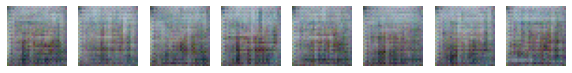

Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50


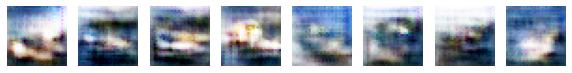

Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50


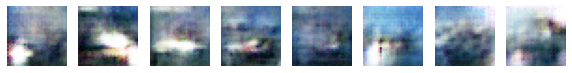

Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50


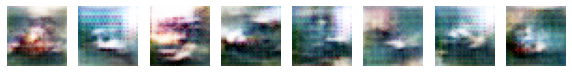

Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50


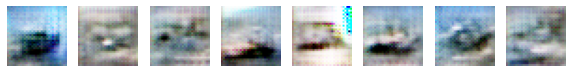

Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50


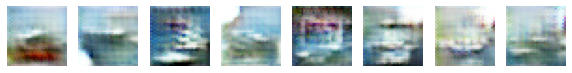

Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50


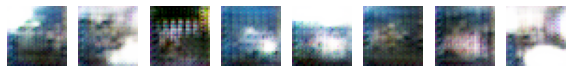

Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50


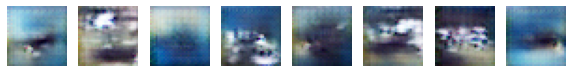

Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50


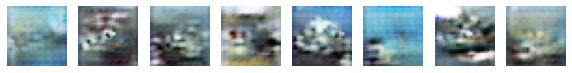

Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50


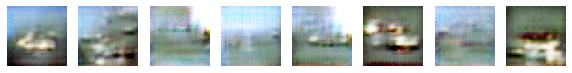

Epoch 47/50
Epoch 48/50
Epoch 49/50


In [ ]:
EPOCHS = 50
fake_images = train_gan(gan, image_dataset, random_normal_dimensions, EPOCHS)

we can see some ship-like images but the resolution of the images is not very good. I am doing some research to improve this.